#  **CNNs for image classification**

-  Visualization of convolutional filters learned by AlexNet pre-trained on ImageNet;
- Performance comparison: Custom CNN, ResNet18, DenseNet. 

In [1]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
%%capture
alexnet = torchvision.models.alexnet(pretrained = True)

In [4]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

CONV1 LAYER: torch.Size([64, 3, 11, 11])


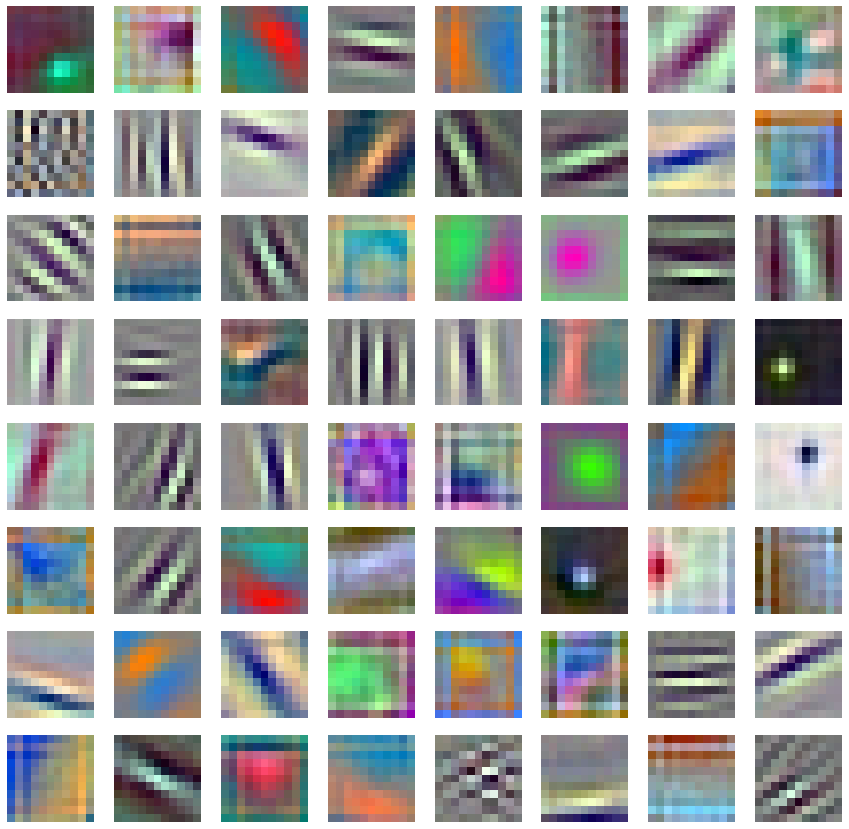

In [5]:
# Get filters
filters = alexnet.features[0].weight.data
print(f"CONV1 LAYER: {filters.shape}")

fig = plt.figure(figsize=(15,15))
for i in range(filters.shape[0]):
  image = filters[i]
  image.clamp_(min = image.min(), max = image.max())
  image.add_(-image.min()).div_(image.max() - image.min() + 1e-5)
  plt.subplot(8, 8, i+1), plt.imshow(image.permute(1,2,0)), plt.axis('off')

# Pre-trained networks as features extractors

A comparison among several pre-trained network is provided on CIFAR-10 dataset.

In [6]:
def create_validation_set(train_data, train_percentage, test_transforms):
    
  # Split train data into train and validation sets
  # (10% of training set will be used as validation set)
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

  print(f"Number training examples: {len(train_data)}")
  print(f"Number validation examples: {len(valid_data)}")

  # Apply test transformations to the validation set
  valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
  valid_data.dataset.transform = test_transforms

  return valid_data

In [7]:
# Dataset loading
%%capture
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

# ----- NORMALIZATION VALUES  -----
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]

# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
#                                                   torchvision.transforms.Resize((224,224)),
#                                                   torchvision.transforms.RandomCrop(32,5),
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
#                                                  torchvision.transforms.Resize((224,224)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(train_mean, train_std)
])

# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)

valid_data = create_validation_set(train_data, 0.8, test_transforms)

# Create iterators
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size=BATCH_SIZE)

In [8]:
# Loss
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy

# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [9]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()
    
    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)
    
    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [10]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(x,y) in iterator:

      x = x.to(device)
      y = y.to(device)
      
      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)
      
      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [11]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.
  
  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [12]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()
    
    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [13]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

In [14]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Test model
  model.load_state_dict(torch.load(model_name))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

In [15]:
def predict(model, iterator, device):
  
  # Evaluation mode
  model.eval()
  
  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)
  
  return labels, pred

In [16]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

In [17]:
OUTPUT_DIM = 10

In [18]:
class CustomCNN(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=2),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU()
    )

    self.linear = nn.Sequential(
        nn.Linear(32 * 4 * 4, 120),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, output_dim)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.linear(x)

    return x

In [19]:
# Custom CNN
customNet = CustomCNN(OUTPUT_DIM)
# Resnet 18
resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, OUTPUT_DIM)
# DenseNet Net 
densenet = torchvision.models.densenet161(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, OUTPUT_DIM)

In [20]:
customNet = customNet.to(device)
resnet18 = resnet18.to(device)
densenet = densenet.to(device)

# Optim
optimizer_custom = optim.RMSprop(customNet.parameters(), lr=1e-3)
optimizer_resnet18 = optim.RMSprop(resnet18.parameters(), lr=1e-3)
optimizer_densenet = optim.RMSprop(densenet.parameters(), lr=1e-3)

In [21]:
## Uncomment the following lines to use the networks as feature extractors
## training only the last FC layer.
# for param in resnet18.parameters():
#   param.requires_grad = False
# resnet18.fc.weight.requires_grad = True
# resnet18.fc.bias.requires_grad = True
# for param in densenet.parameters():
#     param.requires_grad = False
# densenet.classifier.weight.requires_grad = True
# densenet.classifier.bias.requires_grad = True

In [22]:
N_EPOCHS = 30
train_losses_1, train_accs_1, valid_losses_1, valid_accs_1 = model_training(N_EPOCHS, 
                                                                            customNet,
                                                                            train_iterator,
                                                                            valid_iterator,
                                                                            optimizer_custom,
                                                                            criterion,
                                                                            device,
                                                                            'customNet.pt') 


Epoch: 1/30 -- Epoch Time: 8.23 s
---------------------------------
Train -- Loss: 1.826, Acc: 32.44%
Val -- Loss: 1.600, Acc: 40.37%

Epoch: 2/30 -- Epoch Time: 8.25 s
---------------------------------
Train -- Loss: 1.494, Acc: 45.77%
Val -- Loss: 1.423, Acc: 48.17%

Epoch: 3/30 -- Epoch Time: 8.25 s
---------------------------------
Train -- Loss: 1.375, Acc: 50.38%
Val -- Loss: 1.326, Acc: 52.31%

Epoch: 4/30 -- Epoch Time: 8.25 s
---------------------------------
Train -- Loss: 1.296, Acc: 53.34%
Val -- Loss: 1.227, Acc: 54.91%

Epoch: 5/30 -- Epoch Time: 8.27 s
---------------------------------
Train -- Loss: 1.228, Acc: 56.04%
Val -- Loss: 1.168, Acc: 57.84%

Epoch: 6/30 -- Epoch Time: 8.27 s
---------------------------------
Train -- Loss: 1.182, Acc: 57.60%
Val -- Loss: 1.196, Acc: 56.34%

Epoch: 7/30 -- Epoch Time: 8.27 s
---------------------------------
Train -- Loss: 1.136, Acc: 59.26%
Val -- Loss: 1.163, Acc: 58.81%

Epoch: 8/30 -- Epoch Time: 8.26 s
--------------------

In [23]:
N_EPOCHS = 30
train_losses_2, train_accs_2, valid_losses_2, valid_accs_2 = model_training(N_EPOCHS, 
                                                                            resnet18,
                                                                            train_iterator,
                                                                            valid_iterator,
                                                                            optimizer_resnet18,
                                                                            criterion,
                                                                            device,
                                                                            'resnet18.pt') 


Epoch: 1/30 -- Epoch Time: 14.92 s
---------------------------------
Train -- Loss: 1.408, Acc: 49.07%
Val -- Loss: 1.832, Acc: 44.70%

Epoch: 2/30 -- Epoch Time: 14.96 s
---------------------------------
Train -- Loss: 0.704, Acc: 76.12%
Val -- Loss: 0.757, Acc: 73.98%

Epoch: 3/30 -- Epoch Time: 14.54 s
---------------------------------
Train -- Loss: 0.510, Acc: 82.66%
Val -- Loss: 0.952, Acc: 70.46%

Epoch: 4/30 -- Epoch Time: 14.92 s
---------------------------------
Train -- Loss: 0.376, Acc: 87.34%
Val -- Loss: 0.461, Acc: 84.29%

Epoch: 5/30 -- Epoch Time: 14.55 s
---------------------------------
Train -- Loss: 0.279, Acc: 90.81%
Val -- Loss: 0.851, Acc: 75.17%

Epoch: 6/30 -- Epoch Time: 14.58 s
---------------------------------
Train -- Loss: 0.234, Acc: 92.37%
Val -- Loss: 0.539, Acc: 84.13%

Epoch: 7/30 -- Epoch Time: 14.97 s
---------------------------------
Train -- Loss: 0.158, Acc: 94.70%
Val -- Loss: 0.278, Acc: 90.80%

Epoch: 8/30 -- Epoch Time: 14.60 s
------------

In [24]:
train_losses_3, train_accs_3, valid_losses_3, valid_accs_3 = model_training(N_EPOCHS, 
                                                                            densenet,
                                                                            train_iterator,
                                                                            valid_iterator,
                                                                            optimizer_densenet,
                                                                            criterion,
                                                                            device,
                                                                            'densenet.pt') 


Epoch: 1/30 -- Epoch Time: 35.07 s
---------------------------------
Train -- Loss: 1.715, Acc: 38.15%
Val -- Loss: 1.604, Acc: 43.46%

Epoch: 2/30 -- Epoch Time: 35.14 s
---------------------------------
Train -- Loss: 1.195, Acc: 58.62%
Val -- Loss: 1.172, Acc: 58.23%

Epoch: 3/30 -- Epoch Time: 34.21 s
---------------------------------
Train -- Loss: 0.962, Acc: 67.86%
Val -- Loss: 1.446, Acc: 67.46%

Epoch: 4/30 -- Epoch Time: 35.20 s
---------------------------------
Train -- Loss: 0.733, Acc: 75.24%
Val -- Loss: 0.888, Acc: 70.62%

Epoch: 5/30 -- Epoch Time: 35.23 s
---------------------------------
Train -- Loss: 0.620, Acc: 78.75%
Val -- Loss: 0.794, Acc: 75.56%

Epoch: 6/30 -- Epoch Time: 34.21 s
---------------------------------
Train -- Loss: 0.575, Acc: 81.13%
Val -- Loss: 3.168, Acc: 66.21%

Epoch: 7/30 -- Epoch Time: 35.29 s
---------------------------------
Train -- Loss: 0.448, Acc: 84.55%
Val -- Loss: 0.434, Acc: 84.46%

Epoch: 8/30 -- Epoch Time: 34.19 s
------------

In [25]:
model_testing(customNet, test_iterator, criterion, device, 'customNet.pt')

Test -- Loss: 1.068, Acc: 65.56 %


In [26]:
model_testing(resnet18, test_iterator, criterion, device, 'resnet18.pt')

Test -- Loss: 0.962, Acc: 80.06 %


In [27]:
model_testing(densenet, test_iterator, criterion, device, 'densenet.pt')

Test -- Loss: 0.902, Acc: 80.37 %


(None, Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy'))

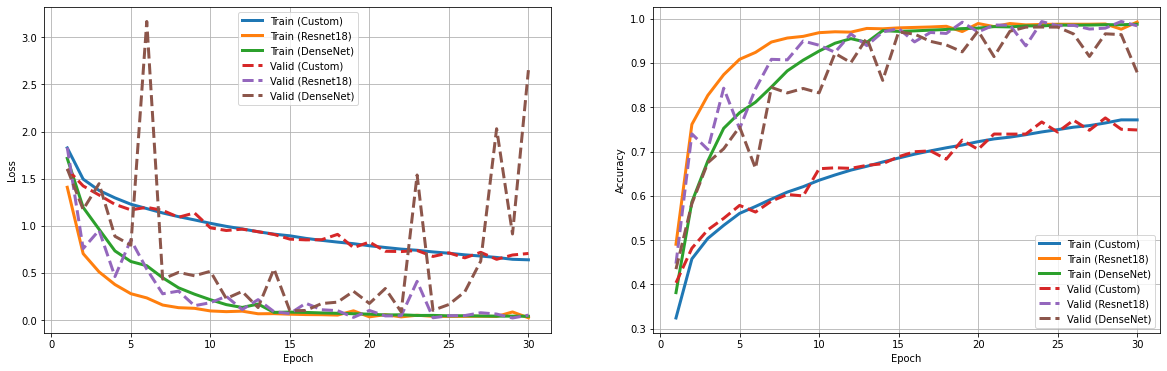

In [28]:
# Plot all results
plt.figure(figsize=(20, 6))
_ = plt.subplot(1,2,1)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_1, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_2, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_losses_3, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_1, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_2, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_losses_3, '--', linewidth=3)
_ = plt.legend(['Train (Custom)', 'Train (Resnet18)', 'Train (DenseNet)', 'Valid (Custom)', 'Valid (Resnet18)', 'Valid (DenseNet)'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

_ = plt.subplot(1,2,2)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_1, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_2, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, train_accs_3, linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_1, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_2, '--', linewidth=3)
plt.plot(np.arange(N_EPOCHS)+1, valid_accs_3, '--', linewidth=3)
_ = plt.legend(['Train (Custom)', 'Train (Resnet18)', 'Train (DenseNet)', 'Valid (Custom)', 'Valid (Resnet18)', 'Valid (DenseNet)'])
plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')